In [47]:
import sagemaker
import numpy as np
import pandas as pd
import transformers
import seaborn as sns
import matplotlib.pyplot as plt
import json

from sagemaker.pytorch import PyTorch
from sklearn.model_selection import train_test_split
from transformers import BertModel, BertTokenizer, BertConfig, AdamW, get_linear_schedule_with_warmup
from matplotlib import rc

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/pytorch-bert"

role = sagemaker.get_execution_role()

We are taking the hyperparameters and architecture used in the other notebook 'tnc_classifier_bert_experiments.ipynb' and creating the same model here. But delegating the running of training job to SageMaker.

In [48]:
NO_OVERLAP_SIZE = 100
MAX_LEN = 128
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
CLASS_NAMES=['Acceptable', 'Unacceptable']

In [49]:
def chunk_text_overlapping (text1):
  full = []
  partial = []
  if len(text1.split())//NO_OVERLAP_SIZE >0:
    n = len(text1.split())//NO_OVERLAP_SIZE
  else:
    n = 1
  for w in range(n):
    if w == 0:
      partial = text1.split()[:MAX_LEN]
      full.append(" ".join(partial))
    else:
      partial = text1.split()[w*NO_OVERLAP_SIZE:w*NO_OVERLAP_SIZE + MAX_LEN]
      full.append(" ".join(partial))
  return full

In [50]:
def prepare_data(input_df):
    data_df = []
    for index, row in input_df.iterrows():
        #cleaned_text = cleanup_text(row['Clause Text'])
        cleaned_text = row['Clause Text']
        chunks = chunk_text_overlapping(cleaned_text)
        for c in chunks:
            data_df.append({'text': c, 'label': row['Classification']})

    df1 = pd.DataFrame(data_df, columns=['text', 'label'])
    return df1

In [51]:
full_data = pd.read_csv('./data/AI_ML_Challenge_Training_Data_Set_1_v1.csv')
df = prepare_data(full_data)
df['text_len'] = df['text'].apply(lambda x: len(x.split()))
df.describe()

,label,text_len
count,9188.000000,9188.000000
mean,0.202329,68.456138
std,0.401758,47.897724
min,0.000000,0.000000
25%,0.000000,23.000000
50%,0.000000,63.000000
75%,0.000000,128.000000
max,1.000000,128.000000


In [52]:
supplement_data = pd.read_csv('./data/AdditionalData.csv')
supplement_data['words_count'] = supplement_data['Clause Text'].apply(lambda x: len(x.split()))
supplement_data.describe()

,Clause ID,Classification,words_count
count,28.000000,28.0,28.000000
mean,10014.500000,1.0,16.071429
std,8.225975,0.0,20.057193
min,10001.000000,1.0,1.000000
25%,10007.750000,1.0,3.750000
50%,10014.500000,1.0,6.500000
75%,10021.250000,1.0,24.000000
max,10028.000000,1.0,91.000000


In [54]:
df1 = prepare_data(supplement_data)
df1['text_len'] = df1['text'].apply(lambda x: len(x.split()))
df = pd.concat([df, df1])

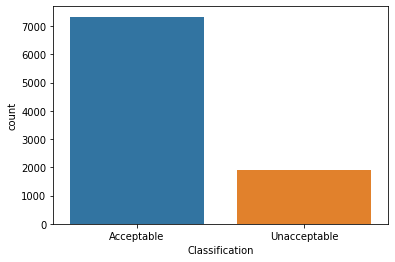

In [55]:
ax = sns.countplot(df['label'])
plt.xlabel('Classification')
ax.set_xticklabels(CLASS_NAMES);

In [56]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

INFO:transformers.tokenization_utils_base:loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt from cache at /root/.cache/torch/transformers/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1


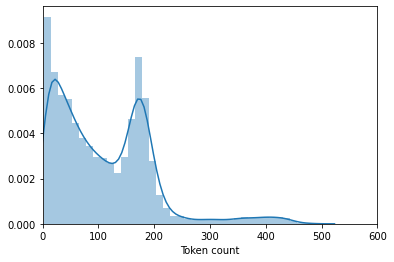

In [57]:
token_lens = []

for txt in df['text']:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 600]);
plt.xlabel('Token count');

In [58]:
train, test = train_test_split(df, test_size=0.05) #test file is not available to SageMaker during training. - TODO
df.to_csv("./data/train.csv", index=False)
test.to_csv("./data/test.csv", index=False)

In [59]:
inputs_train = sagemaker_session.upload_data("./data/train.csv", bucket=bucket, key_prefix=prefix)
inputs_test = sagemaker_session.upload_data("./data/test.csv", bucket=bucket, key_prefix=prefix)

Below is the script to invoke SageMaker training job with right hyperparameters. code for training, deployment and predictions (model_fn, input_fn & predict_fn) are in 'code' directory.

In [60]:
estimator = PyTorch(
    entry_point="train_deploy.py",
    source_dir="code",
    role=role,
    framework_version="1.5.1",
    py_version="py3",
    train_instance_count=1,  # this script only support distributed training for GPU instances.
    train_instance_type="ml.p3.2xlarge",
    hyperparameters={
        "epochs": 4,
        "num_labels": 2,
        "backend": "gloo",
        "seed": 42,
        "batch-size": 16,
        "test-batch-size": 8
    }
)

estimator.fit({"training": inputs_train, "testing": inputs_test})

INFO:sagemaker:Creating training-job with name: pytorch-training-2020-08-20-06-47-04-737


2020-08-20 06:47:05 Starting - Starting the training job...
2020-08-20 06:47:07 Starting - Launching requested ML instances......
2020-08-20 06:48:20 Starting - Preparing the instances for training......
2020-08-20 06:49:32 Downloading - Downloading input data...
2020-08-20 06:50:05 Training - Downloading the training image.........
2020-08-20 06:51:19 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-08-20 06:51:19,684 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2020-08-20 06:51:19,715 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-08-20 06:51:21,216 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-08-20 06:51:21,520 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python -m pip i

After the training job executed, we can see the accuracy is 86%, F1 score is at 0.86 and Brier score is 0.11.

In the next block, we are creating a SageMaker endpoint that can deployed and used by other services for running the inferences. 

In [61]:
predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.m5.large")

INFO:sagemaker:Creating model with name: pytorch-training-2020-08-20-06-47-04-737
INFO:sagemaker:Creating endpoint with name pytorch-training-2020-08-20-06-47-04-737


---------------!

Executing a sample prediction. This shows a sample request and response.
Here is the sample of invokation from a AWS Lambda function (Java)

InvokeEndpointRequest invokeEndpointRequest = InvokeEndpointRequest.builder()
                            .accept("application/json")
                            .contentType("application/json")
                            .endpointName(System.getenv("SM_MODEL_NAME"))
                            .body(SdkBytes.fromUtf8String(json.toString()))
                            .build();

In [62]:
from sagemaker.predictor import json_deserializer, json_serializer

predictor.content_type = "application/json"
predictor.accept = "application/json"
predictor.serializer = json_serializer
predictor.deserializer = json_deserializer

In [76]:
result = predictor.predict({'text': 'Governing Law: This Agreement shall be governed by and interpreted in accordance with the Federal laws of theUnited States, without reference to conflict-of-laws principles. If for any reason a court of competent jurisdiction finds any provision of this Agreement to be unenforceable, that provision will be enforced to the maximum extent possible to effectuate the intent of the parties, and the remainder of this Agreement will continue in full force and effect. This Agreement shall not be governed by the United Nations Convention on Contracts for the International Sale of Goods. Buyer agrees that exclusive jurisdiction for any dispute arising out of or relating to this Agreement lies within the venue mandated by applicable Federal law.'})
print(result)

{'prediction': 0, 'acc_prob': 99.11, 'unacc_prob': 0.89}


In [65]:
val_df = pd.read_csv('./data/AI_ML_Challenge_Validation_Data_Set_v1.csv')
val_df.head()

,Clause ID,Clause Text
0,94,\tthe Customer does not make any admissions (s...
1,7028,Requests. Company will notify Customer before ...
2,9048,We sometimes release beta versions of our webs...
3,7755,Termination without Cause. Customer may termin...
4,1145,1.8 “Term” means the term of this Agreement as...


Using the deployed model to run prediction for the validation dataset

In [74]:
pred_probs = []

for index, row in val_df.iterrows():
    text = row['Clause Text']
    chunks = chunk_text_overlapping(text)
    if len(chunks) > 1:
        parts = []
        for c in chunks:
            result = predictor.predict({'text': c})
            parts.append({"Prediction": result['prediction'], "Probability acceptable": result['acc_prob']})
        df_temp = pd.DataFrame(parts, columns=['Prediction', 'Probability acceptable'])
        pred_probs.append({"Clause ID": row["Clause ID"], "Prediction": df_temp['Prediction'].max(), "Probability acceptable": df_temp['Probability acceptable'].mean()})
    else:
        result = predictor.predict({'text': text})
        pred_probs.append({"Clause ID": row["Clause ID"], "Prediction": result['prediction'], "Probability acceptable": result['acc_prob']})
    
validated_df = pd.DataFrame(pred_probs, columns=["Clause ID", "Prediction", "Probability acceptable"])

validated_df.to_csv("./data/predictions.csv", sep=',')


In [73]:
print(validated_df)

      Clause ID  Prediction  Probability acceptable
0            94           0               98.510000
1          7028           0               98.400000
2          9048           0               93.300000
3          7755           1                2.220000
4          1145           0               99.940000
...         ...         ...                     ...
1386       6590           0               99.940000
1387       2333           0               97.763333
1388       2489           0               99.940000
1389       2548           0               99.920000
1390       7173           0               99.540000

[1391 rows x 3 columns]
